# **Markov Matrices, Random Walks, PageRank**


## By Meher Mankikar and Bharat Narayanasamy

In [1]:
import Pkg

In [2]:
# http://blog.kleinproject.org/?p=280

In [3]:
Pkg.add("GraphRecipes")
Pkg.add("Plots")
Pkg.add("LightGraphs")
Pkg.add("HTTP")
Pkg.add("LinearAlgebra")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [1]:
using LightGraphs
using GraphRecipes
using Plots
using HTTP
using LinearAlgebra

## NAIVE RANDOM WALK IMPLEMENTATION 

In [3]:
# create graph with 5 vertices and 7 random edges
g = SimpleDiGraph(5, 7)

{5, 7} directed simple Int64 graph

In [4]:
h = SimpleDiGraphFromIterator(edges(g));

In [5]:
#Edges of the Random Graph that was created
collect(edges(h))

7-element Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1}:
 Edge 1 => 2
 Edge 1 => 3
 Edge 2 => 3
 Edge 2 => 5
 Edge 3 => 2
 Edge 3 => 5
 Edge 5 => 3

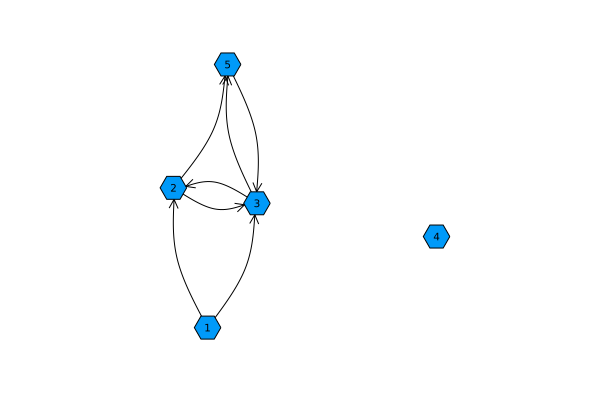

In [6]:
#Plotting the directed graph
graphplot(g, markersize = .2, arrow=true, names=1:nv(g))

In [7]:
# NAIVE RANDOM WALK IMPLEMENTATION
# Starts at a random node on the graph 
# At each iteration pick on of the edges of the current node to move to
# Currently running 11 steps

function randomWalk(g)
    rwp = [0 for i=1:5]
    vert = vertices(g)
    random = rand(1:5) 
    rwp[random] += 1
    neighbors = outneighbors(g, random)
    
    z = 0
    while(z != 10)
        if (length(neighbors) == 0)
            focus = rand(1:5) 
        else
            r1 = rand(1:length(neighbors)) 
            focus = neighbors[r1]
        end
        rwp[focus] += 1
        neighbors = outneighbors(g, focus)
        z += 1
    end
    return rwp
end

randomWalk (generic function with 1 method)

In [8]:
# Results of Random Walk
# Prints the frequencies that each node was visited 
res = randomWalk(g)

5-element Array{Int64,1}:
 0
 2
 4
 0
 5

In [9]:
nodelabel = res

5-element Array{Int64,1}:
 0
 2
 4
 0
 5

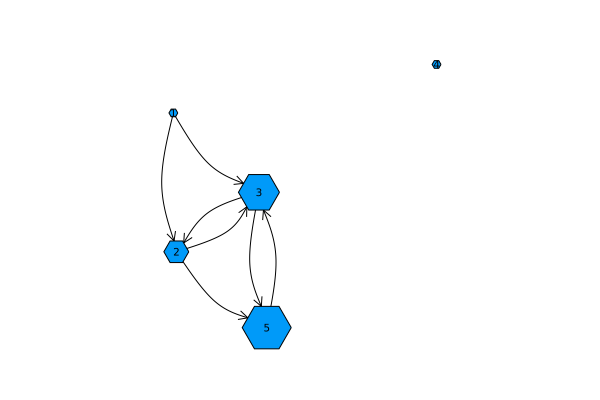

In [10]:
# Graph of Resulting Random Walk
# Nodes that were visited more often are larger

graphplot(g, markersize = .2, arrow=true, names=1:nv(g), nodeweights = nodelabel)

## CREATING A PROBABILITY MATRIX, P

In [11]:
# Data -- 5 connected webpages

url1 = "https://cs.cmu.edu"
url2 = "http://cmu.edu/"
url3 = "https://www.instagram.com/carnegiemellon/"
url4 = "http://www.ml.cmu.edu"
url5 = "https://www.cmu.edu/about/rankings.html"

urls = [url1, url2, url3, url4, url5]

5-element Array{String,1}:
 "https://cs.cmu.edu"
 "http://cmu.edu/"
 "https://www.instagram.com/carnegiemellon/"
 "http://www.ml.cmu.edu"
 "https://www.cmu.edu/about/rankings.html"

In [12]:
# Helper function gets all the links from the webpage

function getLinkList(url)
    resp = HTTP.get(url)
    respText = String(resp.body)
    links = collect(m.match for m in eachmatch(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", respText))
    return links
end

getLinkList (generic function with 1 method)

In [13]:
# Creates list of links on each page 
function listOfLinks()
    lists = Any[]
    for i in 1:length(urls)
        push!(lists, getLinkList(urls[i]))
    end
    lists
end


listOfLinks (generic function with 1 method)

In [14]:
lists = listOfLinks()

5-element Array{Any,1}:
 SubString{String}["http://ogp.me/ns", "http://ogp.me/ns/article", "http://ogp.me/ns/book", "http://ogp.me/ns/profile", "http://ogp.me/ns/video", "http://ogp.me/ns/product", "http://purl.org/rss/1.0/modules/content/", "http://purl.org/dc/terms/", "http://xmlns.com/foaf/0.1/", "http://www.w3.org/2000/01/rdf-schema"  …  "https://www.instagram.com/scsatcmu/", "http://www.cmu.edu/silicon-valley/", "https://apply.tepper.cmu.edu/ping", "http://google.com/ads/remarketingsetup", "https://snap.licdn.com/li.lms-analytics/insight.min.js", "https://dc.ads.linkedin.com/collect/?pid=33075&fmt=gif", "https://www.cs.cmu.edu/sites/all/modules/ie6update/images/", "http://www.microsoft.com/windows/internet-explorer/default.aspx", "https://www.cs.cmu.edu/sites/all/modules/ie6update/ie6update.js", "https://www.cs.cmu.edu/sites/default/files/js/js_7Ukqb3ierdBEL0eowfOKzTkNu-Le97OPm-UqTS5NENU.js"]
 SubString{String}["http://www.cmu.edu/index.html", "http://www.cmu.edu/assets/images/sit

In [15]:
# Creates the probability matrix P     
        
function createP()
    # Creates the probability matrix P 

    P = zeros(Float64, length(urls), length(lists))

    for i in 1:length(lists)
        for j in 1:length(urls)
            if i == j
                continue
            end
            if urls[j] in lists[i]
                P[j,i] = 1
            end
        end
    end
    sum1 = sum(P,dims=1)


    for i in 1:length(urls)
        for j in 1:length(lists)
            if sum1[i] == 0
                break
            end
            P[j,i] = P[j,i]/sum1[i]
        end
    end
    P
end

createP (generic function with 1 method)

In [16]:
P = createP()

5×5 Array{Float64,2}:
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0
 0.5  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0

In [17]:
function plotP()
    # Creates the digraph g
    len = length(urls)
    g = SimpleDiGraph(len)

    for i in 1:length(lists)
        for j in 1:length(urls)
            if P[j,i] != 0
                add_edge!(g, i, j)
            end
        end
    end

    graphplot(g, markersize = .2, arrow=true, names=1:nv(g))
end

plotP (generic function with 1 method)

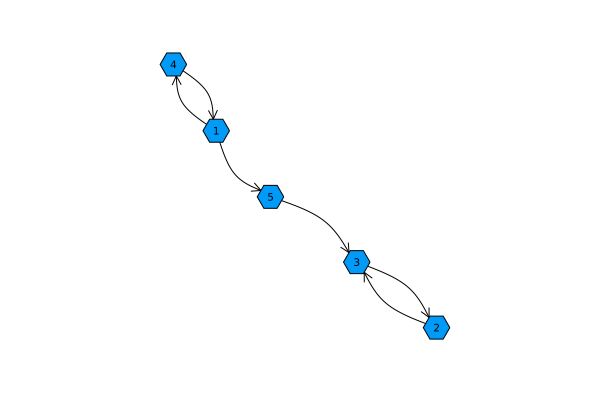

In [18]:
plotP()

## NAIVE RANDOM WALK WITH MARKOV MATRIX

In [19]:
n = length(urls)

5

In [20]:
# Initialize X_0 so that all the values are 1/n

function initializeVec()
    X_0 = zeros(Float64, length(urls))
    fill!(X_0, 1/length(urls))
    X_0
end

initializeVec (generic function with 1 method)

In [21]:
X_0 = initializeVec()

5-element Array{Float64,1}:
 0.2
 0.2
 0.2
 0.2
 0.2

In [22]:
# Performs the Random Walk
function randWalk()
    i = 0
    X = P * X_0
    while i < 150
        X = P * X
        if i % 25 == 0
            print("X_$i: ")
            println(X)
        end
        i += 1
    end
end

randWalk (generic function with 1 method)

In [23]:
randWalk()

X_0: [0.1, 0.4, 0.30000000000000004, 0.1, 0.1]
X_25: [2.44140625e-5, 0.39997558593750004, 0.5999755859375, 1.220703125e-5, 1.220703125e-5]
X_50: [2.9802322387695314e-9, 0.5999999940395355, 0.3999999970197678, 2.9802322387695314e-9, 2.9802322387695314e-9]
X_75: [7.275957614183426e-13, 0.39999999999927244, 0.5999999999992724, 3.637978807091713e-13, 3.637978807091713e-13]
X_100: [8.881784197001253e-17, 0.5999999999999999, 0.39999999999999997, 8.881784197001253e-17, 8.881784197001253e-17]
X_125: [2.168404344971009e-20, 0.4, 0.6, 1.0842021724855045e-20, 1.0842021724855045e-20]


In [24]:
# Diagonalizes P
function diagonalize(P)
    evalue, evec = eigen(P)
    Λ = Diagonal(evalue)
    N = evec
    Ninv = inv(N)
    return evec[:,n]
end

diagonalize (generic function with 1 method)

In [25]:
steadyS = diagonalize(P)

5-element Array{Float64,1}:
  8.777083671441736e-16
 -0.7071067811865476
 -0.7071067811865475
  4.564083509149702e-16
  4.564083509149702e-16

In [26]:
function getSteadyState(v)
    v = v * -(sqrt(2) / 2)
    return v
end

getSteadyState (generic function with 1 method)

In [27]:
getSteadyState(steadyS)

5-element Array{Float64,1}:
 -6.206335383118171e-16
  0.5000000000000001
  0.5
 -3.2272943992214487e-16
 -3.2272943992214487e-16

## PAGERANK IMPLEMENTATION

In [28]:
# Damping factor accounts for people that stop browing over time
Beta = 0.15

0.15

In [29]:
# Initialize X_0 so that all the values are 1/n

function initializeVec()
    X_0 = zeros(Float64, length(urls))
    fill!(X_0, 1/length(urls))
    X_0
end

initializeVec (generic function with 1 method)

In [30]:
initializeVec()

5-element Array{Float64,1}:
 0.2
 0.2
 0.2
 0.2
 0.2

In [31]:
# Creates Q which is initialized with all values being 1 / n
function createQ()
    Q = zeros(Float64, length(urls), length(lists))
    numNodes = length(urls)
    fill!(Q, 1/numNodes)
    return Q
end

createQ (generic function with 1 method)

In [32]:
Q = createQ()

5×5 Array{Float64,2}:
 0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2

In [33]:
# Creates P matrix with damping factor Beta
function createPB()
    P_B = ((1 - Beta) * P) + (Beta * Q)
    return P_B
end

createPB (generic function with 1 method)

In [34]:
P_B = createPB()

5×5 Array{Float64,2}:
 0.03   0.03  0.03  0.88  0.03
 0.03   0.03  0.88  0.03  0.03
 0.03   0.88  0.03  0.03  0.88
 0.455  0.03  0.03  0.03  0.03
 0.455  0.03  0.03  0.03  0.03

In [35]:
# Implements PageRank algorithm
function pagerank()
    i = 0
    X = P_B * X_0
    while i < 100
        X = P_B * X
        if i % 25 == 0
            print("X_$i: ")
            println(X)
        end
        i += 1
    end
    Xsort = sort(X, rev=true)
    used = []
    for i in 1:length(X)
        ind2 = findall(x->x == Xsort[i], X)
        ind = findfirst(x->x == Xsort[i], X)
        
        for j in 1:length(ind2)
            if(!(ind2[j] in used))
                println("Rank $i: $(urls[(ind2[j])])")
                push!(used, ind2[j])
                break
            end
        end
    end
end

pagerank (generic function with 1 method)

In [36]:
pagerank()

X_0: [0.12775, 0.3445000000000001, 0.29775000000000007, 0.115, 0.115]
X_25: [0.08688865585259019, 0.3731109555009213, 0.40614503117178685, 0.06692767873735082, 0.06692767873735082]
X_50: [0.08688845401210182, 0.37427255857285874, 0.4049838015042113, 0.06692759295541392, 0.06692759295541391]
X_75: [0.08688845401174167, 0.37425258449547427, 0.40500377558280354, 0.0669275929549902, 0.06692759295499019]
Rank 1: https://www.instagram.com/carnegiemellon/
Rank 2: http://cmu.edu/
Rank 3: https://cs.cmu.edu
Rank 4: http://www.ml.cmu.edu
Rank 5: https://www.cmu.edu/about/rankings.html


In [37]:
steadState = diagonalize(P_B)

5-element Array{Float64,1}:
 -0.15345444359686275
 -0.6609712946745814
 -0.7152800440702566
 -0.11820139574352939
 -0.11820139574352939

In [38]:
# Manipulates steady state vector so values sum to 1
function getSteadyState2(π)
    π = -1 * π
    s = sum(π)
    π = π / s 
    return π
end

getSteadyState2 (generic function with 1 method)

In [39]:
# Note this vector is the same as the results of PageRank
# When X_0 is multiplied by P_B a large number of times, X will approach a steady state
# which is represented by the eigenvector with eigenvalue 1 of P_B which is shown here

getSteadyState2(steadState)

5-element Array{Float64,1}:
 0.08688845401174161
 0.3742529221981279
 0.40500343788015014
 0.06692759295499015
 0.06692759295499015

## HITS ALGORITHM

In [2]:
## Data
url1A = "https://en.wikipedia.org/wiki/Carnegie_Mellon_University"
url2A = "https://en.wikipedia.org/wiki/Carnegie_Mellon_School_of_Computer_Science"
url3A = "https://en.wikipedia.org/wiki/Human-Computer_Interaction_Institute"
url4A = "https://en.wikipedia.org/wiki/Pittsburgh"
url5A = "https://en.wikipedia.org/wiki/Carnegie_Mellon_University_traditions"
url6A = "https://en.wikipedia.org/wiki/List_of_Turing_Award_laureates_by_university_affiliation"
url7A = "https://en.wikipedia.org/wiki/Robotics"

urlsA = [url1A, url2A, url3A, url4A, url5A, url6A, url7A]

7-element Array{String,1}:
 "https://en.wikipedia.org/wiki/Carnegie_Mellon_University"
 "https://en.wikipedia.org/wiki/Carnegie_Mellon_School_of_Computer_Science"
 "https://en.wikipedia.org/wiki/Human-Computer_Interaction_Institute"
 "https://en.wikipedia.org/wiki/Pittsburgh"
 "https://en.wikipedia.org/wiki/Carnegie_Mellon_University_traditions"
 "https://en.wikipedia.org/wiki/List_of_Turing_Award_laureates_by_university_affiliation"
 "https://en.wikipedia.org/wiki/Robotics"

In [21]:
## Adjacency Matric of Link Structure Above
## (A)_ij = 1 if there exists an edge from i to j, 0 otherwise

A1 = [0 1 1 1 1 1 0 ; 1 0 1 1 1 0 1 ; 1 1 0 1 1 0 0 ; 1 1 0 0 0 0 1 ; 1 1 1 1 0 0 0 ; 1 0 0 0 0 0 0 ; 1 0 0 0 0 0 0]

7×7 Array{Int64,2}:
 0  1  1  1  1  1  0
 1  0  1  1  1  0  1
 1  1  0  1  1  0  0
 1  1  0  0  0  0  1
 1  1  1  1  0  0  0
 1  0  0  0  0  0  0
 1  0  0  0  0  0  0

In [22]:
# Creates vector which is initialized with all values being 1 / sqrt(n)
function createVecs()
    x_0 = zeros(Float64, length(urlsA))
    numNodes = length(urlsA)
    fill!(x_0, 1/sqrt(numNodes))
    return x_0
end

createVecs (generic function with 1 method)

In [5]:
## Initialize x_0 (initial authority weights) and y_0 (intial hub weights)
x_0 = createVecs()
y_0 = createVecs()

7-element Array{Float64,1}:
 0.3779644730092272
 0.3779644730092272
 0.3779644730092272
 0.3779644730092272
 0.3779644730092272
 0.3779644730092272
 0.3779644730092272

In [6]:
## Iterative implementation of HITS for 100 iterations

function hits()
    x_k = normalize(transpose(A1) * (A1) * x_0)
    y_k = normalize(A1 * transpose(A1) * y_0)
    i = 0
    while i < 100
        x_k = normalize(transpose(A1) * A1 * x_k)
        y_k = normalize(A1 * transpose(A1) * y_k)
        i += 1
    end
    return x_k, y_k
end

hits (generic function with 1 method)

In [7]:
## Resulting x_100 and y_100 vectors
X, Y = hits()
println(X)
println(Y)

[0.5100828571185775, 0.43116815209447085, 0.3640946773280714, 0.4830588696890527, 0.36409467732807144, 0.11703846508823482, 0.20429332216312873]
[0.4537883802440175, 0.4966458691951298, 0.4612549226258964, 0.2954521448140663, 0.46125492262589646, 0.1315576098111577, 0.1315576098111577]


In [11]:
A_TA  = transpose(A1) * A1
AA_T = A1 * transpose(A1)

7×7 Array{Int64,2}:
 5  3  3  1  3  0  0
 3  5  3  2  3  1  1
 3  3  4  2  3  1  1
 1  2  2  3  2  1  1
 3  3  3  2  4  1  1
 0  1  1  1  1  1  1
 0  1  1  1  1  1  1

In [12]:
eigenvalues1, eigenvectors1 = eigen(A_TA)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
7-element Array{Float64,1}:
  1.1826288705854266e-15
  0.42564744977974817
  1.0
  1.1260170876321134
  1.7345628594403666
  3.6806393490380596
 15.033133254109714
vectors:
7×7 Array{Float64,2}:
  3.05311e-16   0.315583   -4.97966e-16  …   0.0218619  -0.720193   -0.510083
  0.208514     -0.171288    2.50617e-16      0.757843    0.0579153  -0.431168
  0.417029      0.0799424   0.707107        -0.303611    0.304975   -0.364095
 -0.625543     -0.449662    8.6124e-16      -0.0688019   0.285454   -0.483059
  0.417029      0.0799424  -0.707107        -0.303611    0.304975   -0.364095
 -0.417029      0.802756   -1.33227e-15  …   0.111384    0.355631   -0.117038
 -0.208514     -0.108045    0.0             -0.472965   -0.28981    -0.204293

In [19]:
## Note that the dominant eigenvector of A^TA is the stationary distribution of the authority weights
dom_evec1 = -1 * eigenvectors1[:,length(urlsA)]

7-element Array{Float64,1}:
 0.5100828571185776
 0.43116815209447085
 0.36409467732807144
 0.48305886968905276
 0.3640946773280714
 0.1170384650882349
 0.204293322163129

In [13]:
eigenvalues2, eigenvectors2 = eigen(AA_T)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
7-element Array{Float64,1}:
 -2.2204460596972335e-16
  0.42564744977974617
  0.9999999999999996
  1.1260170876321118
  1.7345628594403675
  3.680639349038064
 15.033133254109712
vectors:
7×7 Array{Float64,2}:
  6.10623e-16   0.523731   -2.22045e-16  …   0.146696   -0.682279   -0.453788
 -5.55112e-17  -0.126053    1.76016e-16     -0.855811    0.0597339  -0.496646
 -5.55112e-16  -0.345523    0.707107         0.309251    0.0374504  -0.461255
 -1.11022e-16   0.0555628  -5.03996e-16      0.232904    0.496267   -0.295452
 -4.996e-16    -0.345523   -0.707107         0.309251    0.0374504  -0.461255
 -0.707107      0.483713    1.20505e-16  …   0.0165994   0.375394   -0.131558
  0.707107      0.483713    0.0              0.0165994   0.375394   -0.131558

In [20]:
## Note that the dominant eigenvector of AA^T is the stationary distribution of the hub weights
dom_evec2 = -1 * eigenvectors2[:,length(urlsA)]

7-element Array{Float64,1}:
 0.4537883802440176
 0.49664586919512976
 0.4612549226258963
 0.2954521448140661
 0.4612549226258963
 0.13155760981115738
 0.13155760981115783